In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import os
import numpy as np

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


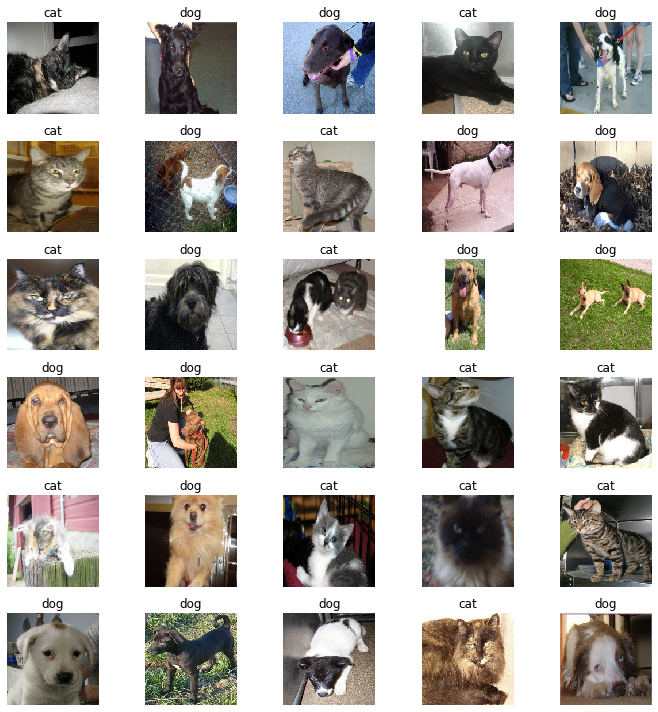

In [9]:
# 1) TFDS label to split dataset

SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs', 
                                                            split=list(splits), 
                                                            with_info=True, 
                                                            as_supervised=True)

############################################################

# 2) Datasets to (image, label) datasets

IMG_SIZE = (160, 160) # All images will be resized to 160x160

def format_data(image, label):
    image = tf.cast(image, tf.float32) / 255 #might need to change to (image/127.5) - 1 since apparently scaled to [-1,1]
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

train = raw_train.map(format_data)
validation = raw_validation.map(format_data)
test = raw_test.map(format_data)

############################################################

# 3) Datasets to batched dataset

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = (train
                 .shuffle(SHUFFLE_BUFFER_SIZE)
                 .batch(BATCH_SIZE))
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)



############################################################

# 4) Datasets to image display

get_label_name = metadata.features['label'].int2str

def plotImages(batch):
    img, label = batch
    
    plt.figure(figsize=(10,10))
    
    for n in range(30):
        
        plt.subplot(6,5,n+1)
        plt.imshow(img[n])
        plt.title(get_label_name(label[n]))
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

sample_train_batch = next(iter(train_batches))
plotImages(sample_train_batch) 


In [3]:
OUTPUT_CHANNELS = 3
IMG_SHAPE = (*IMG_SIZE, OUTPUT_CHANNELS)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

global_average_layer = keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(1)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=0.00001),
              metrics=['accuracy'])

model.summary()

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)



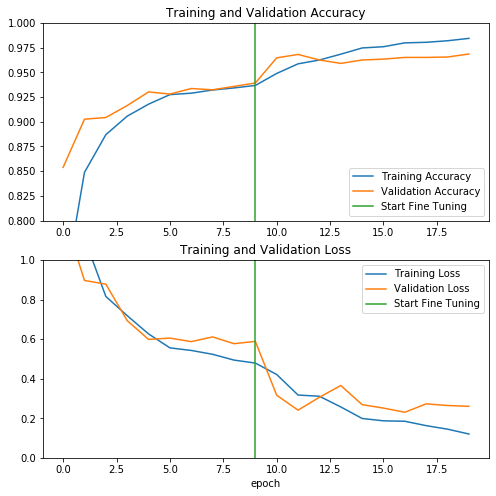

In [19]:
acc  = history.history['accuracy'] +  history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
